# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.nn.functional import softmax
import pandas as pd

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда.



In [ ]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)

    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3,
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader

In [ ]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64,
                                                         transform_train=transform)

100%|██████████| 170498071/170498071 [00:03<00:00, 43505243.18it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Посмотрим на изображения:

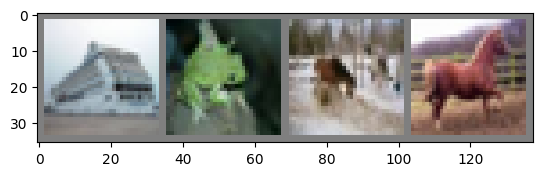

ship frog horse horse


In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [ ]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):

        super().__init__()

        self.conv3first = nn.Conv2d(3, 32, 3, padding = 1)
        self.batchNormFirst = nn.BatchNorm2d(32)
        self.conv3second = nn.Conv2d(32, 32, 3, padding = 1)
        self.batchNormSecond = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()

        self.conv1 = nn.Conv2d(3, 32, 1)

        self.avgpool = nn.AvgPool2d(kernel_size=8)
        self.linear = nn.Linear(512, 10)


    def forward(self, x):
        residual = self.conv1(x)
        out = self.batchNormSecond(
            self.conv3second(
                self.relu(
                    self.batchNormFirst(
                        self.conv3first(x))))) + residual
        out = self.relu(out)
        out = self.avgpool(out)
        out = out.view(-1, 512)
        out = self.linear(out)

        return out

In [ ]:
net = BasicBlockNet()
net

BasicBlockNet(
  (conv3first): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchNormFirst): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3second): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchNormSecond): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv1): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (avgpool): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (linear): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [ ]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [ ]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    criterion = nn.CrossEntropyLoss()

    for data, target in loader:

        data = data.to(device)
        target = target.to(device)

        # loss
        prediction = model(data)
        loss = criterion(prediction, target)
        loss_log.append(loss.item())

        # accuracy
        probas = softmax(prediction, dim=1)
        pred_classes = probas.argmax(dim=1)
        acc = accuracy_score(target.cpu(), pred_classes.cpu())
        acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)


def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    criterion = nn.CrossEntropyLoss()

    for data, target in train_loader:

        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()

        pred = model(data)
        loss = criterion(pred, target)
        loss_log.append(loss.item())

        # backpropagation
        loss.backward()
        optimizer.step()


        probas = softmax(pred, dim=1)
        pred_classes = probas.argmax(dim=1)
        acc = accuracy_score(target.cpu(), pred_classes.cpu())
        acc_log.append(acc.item())

    return loss_log, acc_log


def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []


    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.500286310747729, train acc: 0.4641510511882998
 val loss: 1.3228859947082845, val acc: 0.5326906028368794

Epoch 1
 train loss: 1.2071319902400865, train acc: 0.5728649778009924
 val loss: 1.121745312974808, val acc: 0.6105053191489361

Epoch 2
 train loss: 1.0707777845358282, train acc: 0.626856718464351
 val loss: 1.1450326381845677, val acc: 0.6084884751773051

Epoch 3
 train loss: 1.0028258716820362, train acc: 0.6504023570122748
 val loss: 1.0253575266675745, val acc: 0.6447695035460992

Epoch 4
 train loss: 0.9587076590745497, train acc: 0.6660640833115695
 val loss: 0.9843625832111278, val acc: 0.6564494680851064

Epoch 5
 train loss: 0.9327457601671028, train acc: 0.6776491903891355
 val loss: 0.9395615899816473, val acc: 0.6735372340425532

Epoch 6
 train loss: 0.9005340443450747, train acc: 0.6881039435884042
 val loss: 0.9365283971137189, val acc: 0.6794547872340425

Epoch 7
 train loss: 0.889951920215129, train acc: 0.6899973883520502
 val loss: 0.917

**Модель переобучается.**

Посчитайте точность на тестовой выборке:

In [ ]:
loss_test, acc_test = test(net, test_loader)
print(f'Loss on test: {loss_test}, accuracy on test: {acc_test}')

Loss on test: 0.8543250133657152, accuracy on test: 0.7056130573248408


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

In [ ]:
train_loss_plot = np.array(train_loss_log)
train_acc_plot = np.array(train_acc_log)
val_loss_plot = np.array(val_loss_log)
val_acc_plot = np.array(val_acc_log)

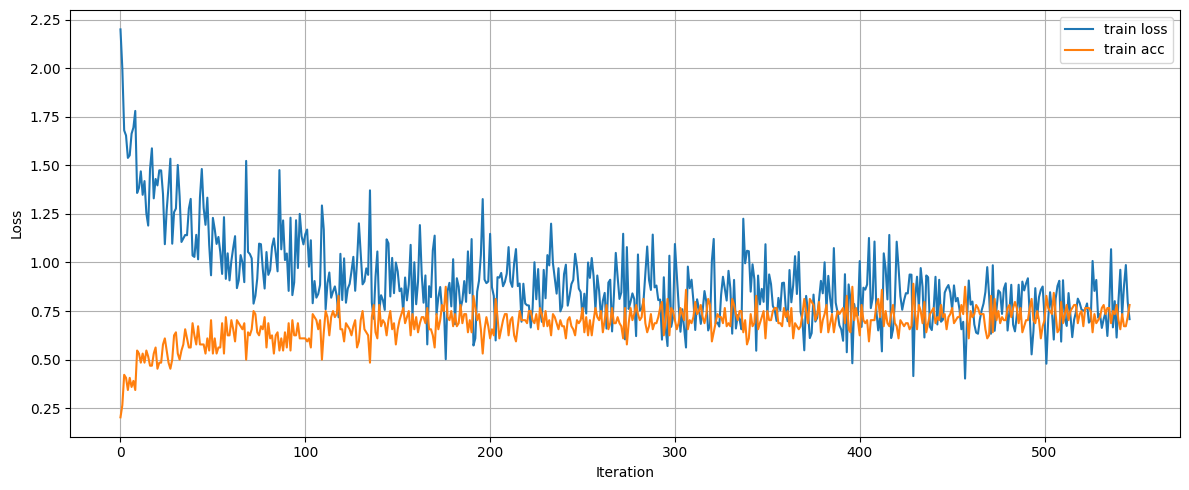

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(train_loss_plot[::20], label="train loss")
ax.plot(train_acc_plot[::20], label="train acc")
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.grid(True)
ax.legend()

fig.tight_layout()
plt.show()

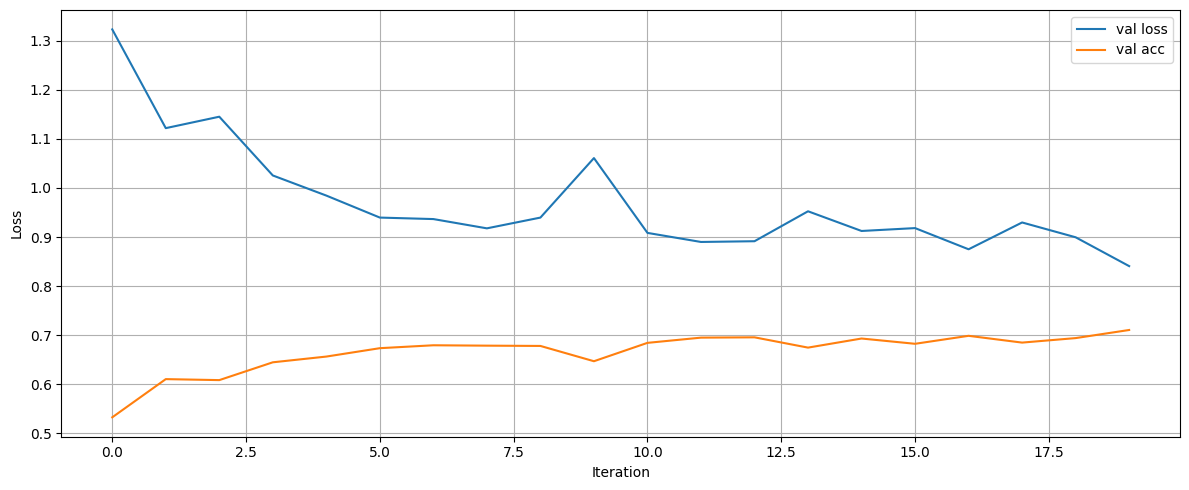

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(val_loss_plot, label="val loss")
ax.plot(val_acc_plot, label="val acc")
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.grid(True)
ax.legend()

fig.tight_layout()
plt.show()

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4974265613983058, train acc: 0.46743193392530685
 val loss: 1.343780128499295, val acc: 0.5293882978723404

Epoch 1
 train loss: 1.1589947719896516, train acc: 0.5959699007573779
 val loss: 1.0669040314694669, val acc: 0.6299645390070923

Epoch 2
 train loss: 1.0413404745637171, train acc: 0.6345284343170541
 val loss: 1.0057366254481863, val acc: 0.6503102836879433

Epoch 3
 train loss: 0.9844895265655936, train acc: 0.6579720553669365
 val loss: 0.9375739703787134, val acc: 0.6746010638297872

Epoch 4
 train loss: 0.9413948439374921, train acc: 0.6731808239749282
 val loss: 0.9174750510682451, val acc: 0.6862367021276595

Epoch 5
 train loss: 0.9248183927544728, train acc: 0.6797099438495691
 val loss: 0.9208327777842258, val acc: 0.6832668439716312

Epoch 6
 train loss: 0.8960599125630241, train acc: 0.6875448876991381
 val loss: 0.956759501771724, val acc: 0.6763962765957446

Epoch 7
 train loss: 0.8788752661544619, train acc: 0.6937026638809088
 val loss: 0.

Посчитайте точность на тестовой выборке:

In [ ]:
loss_test, acc_test = test(net, test_loader)
print(f'Loss on test: {loss_test}, accuracy on test: {acc_test}')

Loss on test: 0.8225638748733861, accuracy on test: 0.7218351910828026


**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.828548781178769, train acc: 0.35811406372421
 val loss: 1.6273217328051304, val acc: 0.4312056737588653

Epoch 1
 train loss: 1.5442540996471315, train acc: 0.4572873139200836
 val loss: 1.4568411553159673, val acc: 0.48636968085106386

Epoch 2
 train loss: 1.418555480470605, train acc: 0.5028442478453904
 val loss: 1.3666576355061633, val acc: 0.5183067375886525

Epoch 3
 train loss: 1.3408543975305296, train acc: 0.5302706320188039
 val loss: 1.3158771996802472, val acc: 0.535549645390071

Epoch 4
 train loss: 1.2865691056417154, train acc: 0.5513923348132671
 val loss: 1.2560649024679307, val acc: 0.5634086879432625

Epoch 5
 train loss: 1.2434912257482191, train acc: 0.5637895011752415
 val loss: 1.2128128921731989, val acc: 0.5731826241134752

Epoch 6
 train loss: 1.203076961816338, train acc: 0.5824709454165578
 val loss: 1.1882422604459397, val acc: 0.5872118794326242

Epoch 7
 train loss: 1.166158540157339, train acc: 0.5941213436928702
 val loss: 1.14624

In [ ]:
loss_test, acc_test = test(net, test_loader)
print(f'Loss on test: {loss_test}, accuracy on test: {acc_test}') # действительно, получили худшее качество

Loss on test: 1.0060003073352157, accuracy on test: 0.6416202229299363


**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

Решено использовать следующие способы:

- Lambda LR
- Exponential LR
- Cyclic LR (triangular2)

Источник:

https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling

#### Lambda LR

Принцип работы:

Применяет каждую эпоху к темпу обучения лямбда-функцию от эпохи, определённую пользователем.

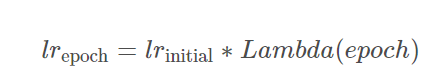

In [ ]:
res = {}

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
lambda1 = lambda epoch: 0.7 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.5048603641049736, train acc: 0.4634083638025594
 val loss: 1.4451127666108152, val acc: 0.49073581560283686

Epoch 1
 train loss: 1.16160610759498, train acc: 0.5925992426220945
 val loss: 1.1183907978078151, val acc: 0.6096631205673758

Epoch 2
 train loss: 1.0285398706221711, train acc: 0.639772133716375
 val loss: 1.0632101150269204, val acc: 0.6269725177304966

Epoch 3
 train loss: 0.9633964421108392, train acc: 0.664692968137895
 val loss: 0.969666610880101, val acc: 0.6664450354609929

Epoch 4
 train loss: 0.9131418373946516, train acc: 0.6844394750587621
 val loss: 0.9641837690738921, val acc: 0.6662677304964539

Epoch 5
 train loss: 0.8865178296073482, train acc: 0.692976299294855
 val loss: 0.9290014340522441, val acc: 0.6762632978723404

Epoch 6
 train loss: 0.8606548449892885, train acc: 0.7011458605379995
 val loss: 0.8941032189003965, val acc: 0.6899601063829788

Epoch 7
 train loss: 0.8419129932384386, train acc: 0.7098540741708017
 val loss: 0.8846

In [ ]:
loss_test, acc_test = test(net, test_loader)
print(f'Loss on test: {loss_test}, accuracy on test: {acc_test}')

Loss on test: 0.8743674591848045, accuracy on test: 0.6986464968152867


In [ ]:
res['scheduler'] = scheduler
res['train_acc'] = round(np.array(tr_acc_log).mean(), 3)
res['test_acc'] = round(acc_test, 3)

#### Exponential LR

Принцип работы:

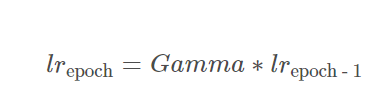

In [ ]:
res = {}

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.5124325560477359, train acc: 0.46011523896578743
 val loss: 1.2901483239011562, val acc: 0.546764184397163

Epoch 1
 train loss: 1.163731839146867, train acc: 0.5911914011491252
 val loss: 1.1408404398471752, val acc: 0.6017730496453901

Epoch 2
 train loss: 1.1067332214585606, train acc: 0.6153450639853748
 val loss: 1.114470556188137, val acc: 0.6097517730496455

Epoch 3
 train loss: 1.0971636888749856, train acc: 0.6172221859493341
 val loss: 1.1125640572385584, val acc: 0.6102836879432625

Epoch 4
 train loss: 1.0960290787206926, train acc: 0.6160591864716636
 val loss: 1.1128319329403817, val acc: 0.6096187943262412

Epoch 5
 train loss: 1.0958987971328513, train acc: 0.6171528140506659
 val loss: 1.1131637821806237, val acc: 0.6113475177304966

Epoch 6
 train loss: 1.0973498196880822, train acc: 0.616381561765474
 val loss: 1.1130226089599284, val acc: 0.609552304964539

Epoch 7
 train loss: 1.0970206297729743, train acc: 0.6152348850874901
 val loss: 1.112

In [ ]:
loss_test, acc_test = test(net, test_loader)
print(f'Loss on test: {loss_test}, accuracy on test: {acc_test}')

Loss on test: 1.1133248745256168, accuracy on test: 0.6114649681528662


In [ ]:
res['scheduler'] = scheduler
res['train_acc'] = round(np.array(tr_acc_log).mean(), 3)
res['test_acc'] = round(acc_test, 3)

#### Cyclic LR (triangular2)

Принцип работы:

Шкалирует темп обучения от одного значения до другого с постоянной частотой.
Конкретно triangular2 - уменьшает амплитуду значений дважды каждый цикл.
Наглядно показано на графике:
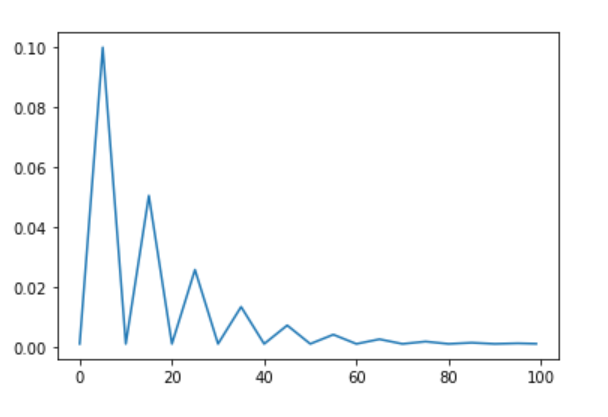

In [ ]:
res = {}

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1,step_size_up=5,mode="triangular2")
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.8290854171599504, train acc: 0.36220292504570384
 val loss: 1.587820986991233, val acc: 0.4495789007092198

Epoch 1
 train loss: 1.4060310462057264, train acc: 0.49927363541394615
 val loss: 1.28193007377868, val acc: 0.5482269503546099

Epoch 2
 train loss: 1.1758136877847982, train acc: 0.5830340820057457
 val loss: 1.1192488229021114, val acc: 0.6087765957446809

Epoch 3
 train loss: 1.06528399685837, train acc: 0.6261425959780622
 val loss: 1.0600024383118811, val acc: 0.6255097517730497

Epoch 4
 train loss: 1.0130790663811582, train acc: 0.6466562744841995
 val loss: 1.0344378867047899, val acc: 0.6455008865248226

Epoch 5
 train loss: 0.9711624545196729, train acc: 0.6641094280490989
 val loss: 1.0564824814492084, val acc: 0.636502659574468

Epoch 6
 train loss: 0.9170810397189976, train acc: 0.6824725776965265
 val loss: 0.9340555170749096, val acc: 0.6761081560283688

Epoch 7
 train loss: 0.8729548168792585, train acc: 0.6980037215983286
 val loss: 0.944

In [ ]:
loss_test, acc_test = test(net, test_loader)
print(f'Loss on test: {loss_test}, accuracy on test: {acc_test}')

Loss on test: 0.8102808332746956, accuracy on test: 0.7267117834394905


In [ ]:
res['scheduler'] = scheduler
res['train_acc'] = round(np.array(tr_acc_log).mean(), 3)
res['test_acc'] = round(acc_test, 3)

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

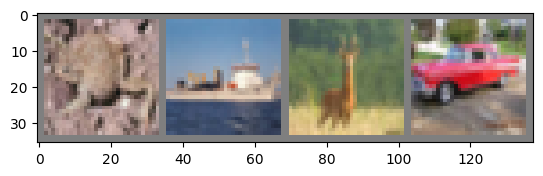

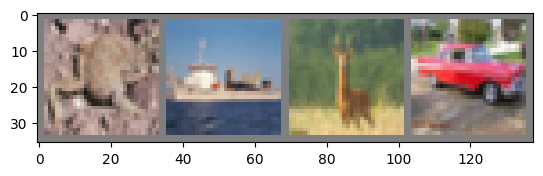

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:4]))
imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [ ]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4872002451249842, train acc: 0.46881937189866807
 val loss: 1.292073095098455, val acc: 0.5373670212765957

Epoch 1
 train loss: 1.1922727429888584, train acc: 0.5782555823974928
 val loss: 1.1320864350237745, val acc: 0.6042109929078013

Epoch 2
 train loss: 1.0611173675090784, train acc: 0.6266975711674067
 val loss: 1.1009228752014484, val acc: 0.623293439716312

Epoch 3
 train loss: 1.0011595579126418, train acc: 0.6532506855575868
 val loss: 0.9744811448645084, val acc: 0.6645833333333333

Epoch 4
 train loss: 0.9609853526138082, train acc: 0.6667047531992687
 val loss: 1.013816922268969, val acc: 0.6462544326241135

Epoch 5
 train loss: 0.9246127161944806, train acc: 0.6782653760773047
 val loss: 0.9387851413260115, val acc: 0.670700354609929

Epoch 6
 train loss: 0.9093084226360705, train acc: 0.6871898668059545
 val loss: 0.9505320320738123, val acc: 0.6714095744680851

Epoch 7
 t

Посчитайте точность на тестовой выборке:

In [ ]:
loss_test, acc_test = test(net, test_loader)
print(f'Loss on test: {loss_test}, accuracy on test: {acc_test}')

Loss on test: 0.798238095584189, accuracy on test: 0.7263136942675159


**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

Аугментацию проведу по следующей схеме:

1. Rotation
2. Vertical Flip
3. ColorJitter
4. Horizontal Flip + Rotation
5. HorizontalFlip + ColorJitter

#### Rotation

In [ ]:
res = {}

In [ ]:
transform = transforms.Compose(
        [transforms.RandomRotation(30),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.612371337043302, train acc: 0.41954492034473756
 val loss: 1.4145832193658707, val acc: 0.4865248226950355

Epoch 1
 train loss: 1.3901937092897878, train acc: 0.5071861125620266
 val loss: 1.282690961310204, val acc: 0.5487810283687944

Epoch 2
 train loss: 1.2951626172885162, train acc: 0.5434104857665187
 val loss: 1.2587040850456725, val acc: 0.5528368794326242

Epoch 3
 train loss: 1.242239266034672, train acc: 0.5602800992426221
 val loss: 1.2053776193172374, val acc: 0.573049645390071

Epoch 4
 train loss: 1.1968084100831362, train acc: 0.5772190846173936
 val loss: 1.1782574671380064, val acc: 0.5875221631205673

Epoch 5
 train loss: 1.1665627329833328, train acc: 0.5907466048576653
 val loss: 1.2512995839118957, val acc: 0.56292109929078

Epoch 6
 train loss: 1.1395726790157925, train acc: 0.5978184578218856
 val loss: 1.1304298639297485, val acc: 0.5975398936170213

Epoch 7
 tra

In [ ]:
loss_test, acc_test = test(net, test_loader)
print(f'Loss on test: {loss_test}, accuracy on test: {acc_test}')

Loss on test: 0.9039893845084367, accuracy on test: 0.6882961783439491


In [ ]:
res['augm_method'] = 'Rotation'
res['train_acc'] = round(np.array(tr_acc_log).mean(), 3)
res['test_acc'] = round(acc_test, 3)

#### Vertical Flip

In [ ]:
res = {}

In [ ]:
transform = transforms.Compose(
        [transforms.RandomVerticalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.6519781468773236, train acc: 0.3985089122486289
 val loss: 1.5018039069277176, val acc: 0.4516622340425532

Epoch 1
 train loss: 1.3888736949106457, train acc: 0.5060639200835727
 val loss: 1.2756640096928211, val acc: 0.5494902482269503

Epoch 2
 train loss: 1.2726124032541863, train acc: 0.5467280948028206
 val loss: 1.2231788840699702, val acc: 0.5652703900709221

Epoch 3
 train loss: 1.2132552800056486, train acc: 0.5715795573256726
 val loss: 1.1762602171999343, val acc: 0.5873448581560284

Epoch 4
 train loss: 1.1695549628634339, train acc: 0.5845684251762862
 val loss: 1.217036666007752, val acc: 0.5662455673758865

Epoch 5
 train loss: 1.1351673694589675, train acc: 0.5964922303473492
 val loss: 1.1554970972081449, val acc: 0.5906028368794327

Epoch 6
 train loss: 1.1056678466212815, train acc: 0.6111909114651345
 val loss: 1.1435747334297668, val acc: 0.5928413120567375

Epoch 7


In [ ]:
loss_test, acc_test = test(net, test_loader)
print(f'Loss on test: {loss_test}, accuracy on test: {acc_test}')

Loss on test: 0.9659331923077821, accuracy on test: 0.664609872611465


In [ ]:
res['augm_method'] = 'VerticalFlip'
res['train_acc'] = round(np.array(tr_acc_log).mean(), 3)
res['test_acc'] = round(acc_test, 3)

#### ColorJitter

Изменяет яркость, контраст и насыщенность изображений

In [ ]:
res = {}

In [ ]:
transform = transforms.Compose(
        [transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0, hue=0),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.5048799230368088, train acc: 0.46270240271611385
 val loss: 1.2813070738569219, val acc: 0.5416666666666667

Epoch 1
 train loss: 1.1994736650090332, train acc: 0.5800878166623139
 val loss: 1.2880839226093699, val acc: 0.5613696808510639

Epoch 2
 train loss: 1.068973468470181, train acc: 0.6294969313136589
 val loss: 1.1091816372059762, val acc: 0.6238696808510639

Epoch 3
 train loss: 0.9967881841023182, train acc: 0.6513613214938627
 val loss: 0.9920498447215303, val acc: 0.6570035460992907

Epoch 4
 train loss: 0.9574247494040286, train acc: 0.6691123661530426
 val loss: 1.0440052643735358, val acc: 0.6310505319148936

Epoch 5
 train loss: 0.9250364576004977, train acc: 0.6797344280490989
 val loss: 0.9888677843073581, val acc: 0.6497118794326242

Epoch 6
 train loss: 0.9079378442310981, train acc: 0.6847822538521808
 val loss: 1.000293102670223, val acc: 0.6506648936170213

Epoch 7


In [ ]:
loss_test, acc_test = test(net, test_loader)
print(f'Loss on test: {loss_test}, accuracy on test: {acc_test}')

Loss on test: 0.8162895198080949, accuracy on test: 0.7211385350318471


In [ ]:
res['augm_method'] = 'ColorJitter'
res['train_acc'] = round(np.array(tr_acc_log).mean(), 3)
res['test_acc'] = round(acc_test, 3)
augm_tot.append(res)

#### HorizontalFlip + Rotation

In [ ]:
res = {}

In [ ]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.RandomRotation(30),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.618021498650476, train acc: 0.4186145207626012
 val loss: 1.435454660273613, val acc: 0.4808510638297872

Epoch 1
 train loss: 1.389375394288539, train acc: 0.5071616283624968
 val loss: 1.3081936278241746, val acc: 0.5273271276595745

Epoch 2
 train loss: 1.2898492959125387, train acc: 0.5427004439801515
 val loss: 1.2480122411504704, val acc: 0.5614804964539007

Epoch 3
 train loss: 1.2331814176421714, train acc: 0.560806509532515
 val loss: 1.1851276494087057, val acc: 0.5878989361702127

Epoch 4
 train loss: 1.1899145537582132, train acc: 0.5817731457299556
 val loss: 1.194714805166772, val acc: 0.5808067375886524

Epoch 5
 train loss: 1.1549175905789055, train acc: 0.5916198746408985
 val loss: 1.1554362570985834, val acc: 0.5879654255319149

Epoch 6
 train loss: 1.1364235861645755, train acc: 0.599295671193523
 val loss: 1.1508436479467026, val acc: 0.5929964539007093

Epoch 7
 trai

In [ ]:
loss_test, acc_test = test(net, test_loader)
print(f'Loss on test: {loss_test}, accuracy on test: {acc_test}')

Loss on test: 0.8718702544452278, accuracy on test: 0.6944665605095541


In [ ]:
res['augm_method'] = 'HorizontalFlip + Rotation'
res['train_acc'] = round(np.array(tr_acc_log).mean(), 3)
res['test_acc'] = round(acc_test, 3)

#### HorizontalFlip + ColorJitter

In [ ]:
res = {}

In [ ]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0, hue=0),
         transforms.RandomRotation(30),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.625163191633207, train acc: 0.415207136328023
 val loss: 1.4252492559717056, val acc: 0.4935948581560283

Epoch 1
 train loss: 1.4056372707896956, train acc: 0.4989186145207625
 val loss: 1.3058446343908918, val acc: 0.5379432624113475

Epoch 2
 train loss: 1.311605354331747, train acc: 0.5351470684251763
 val loss: 1.276624565175239, val acc: 0.550997340425532

Epoch 3
 train loss: 1.2600325745899892, train acc: 0.5558525398276313
 val loss: 1.2096810262253943, val acc: 0.5744902482269503

Epoch 4
 train loss: 1.2171553517172498, train acc: 0.5715836380255942
 val loss: 1.164527705882458, val acc: 0.5890070921985816

Epoch 5
 train loss: 1.1827921209213286, train acc: 0.5824464612170279
 val loss: 1.1706310239244015, val acc: 0.5905363475177305

Epoch 6
 train loss: 1.1567927451848548, train acc: 0.5941743927918517
 val loss: 1.1670544286991686, val acc: 0.5909796099290779

Epoch 7
 trai

In [ ]:
loss_test, acc_test = test(net, test_loader)
print(f'Loss on test: {loss_test}, accuracy on test: {acc_test}')

Loss on test: 0.8827934959891496, accuracy on test: 0.6907842356687898


In [ ]:
res['augm_method'] = 'HorizontalFlip + ColorJitter'
res['train_acc'] = round(np.array(tr_acc_log).mean(), 3)
res['test_acc'] = round(acc_test, 3)

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [ ]:
!pip install --upgrade wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.7/251.7 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00


In [ ]:
import wandb

In [ ]:
run = wandb.init(project="shw-02 PI21-7 Gusmanova EE")
config = run.config
config.dropout = 0.01

train acc,▁█
train loss,█▁
val acc,▁▃█▁▅
val loss,▇▆▁█▄
train acc,0.49913
train loss,1.40252
val acc,0.51769
val loss,1.35695


In [ ]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    criterion = nn.CrossEntropyLoss()


    for data, target in loader:

        data = data.to(device)
        target = target.to(device)

        prediction = model(data)
        loss = criterion(prediction, target)
        loss_log.append(loss.item())

        probas = softmax(prediction, dim=1)
        pred_classes = probas.argmax(dim=1)
        acc = accuracy_score(target.cpu(), pred_classes.cpu())
        acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)


def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    criterion = nn.CrossEntropyLoss()

    for data, target in train_loader:

        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()

        pred = model(data)
        loss = criterion(pred, target)
        loss_log.append(loss.item())

        loss.backward()
        optimizer.step()

        probas = softmax(pred, dim=1)
        pred_classes = probas.argmax(dim=1)
        acc = accuracy_score(target.cpu(), pred_classes.cpu())
        acc_log.append(acc.item())

    return np.array(loss_log).mean(), np.array(acc_log).mean()

def train(model, optimizer, n_epochs, train_loader, val_loader, run, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.append(train_loss)
        train_acc_log.append(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        run.log({"train loss": train_loss})
        run.log({"train acc": train_acc})
        run.log({"val loss": val_loss})
        run.log({"val acc": val_acc})

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
run.watch(net)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, run)

Epoch 0
 train loss: 1.6143372058868408, train acc: 0.42061814442413165
 val loss: 1.4695376588943156, val acc: 0.46932624113475174

Epoch 1
 train loss: 1.3996496504577902, train acc: 0.5008120592844085
 val loss: 1.3347874189944977, val acc: 0.5285017730496454

Epoch 2
 train loss: 1.300437091582436, train acc: 0.5383463371637504
 val loss: 1.2425364299023405, val acc: 0.5551196808510638

Epoch 3
 train loss: 1.244750463657449, train acc: 0.5553628558370332
 val loss: 1.2005007008288768, val acc: 0.5738696808510638

Epoch 4
 train loss: 1.2157255040662163, train acc: 0.5680130255941499
 val loss: 1.3048233755091403, val acc: 0.5506870567375886

Epoch 5
 train loss: 1.1725140285884224, train acc: 0.5848132671715852
 val loss: 1.1918525728773564, val acc: 0.5848404255319148

Epoch 6
 train loss: 1.1581336229331314, train acc: 0.588167602507182
 val loss: 1.1340616916088349, val acc: 0.5952792553191489

Epoch 7
 train loss: 1.1401816946496912, train acc: 0.594741610080961
 val loss: 1.1

**Результаты**:

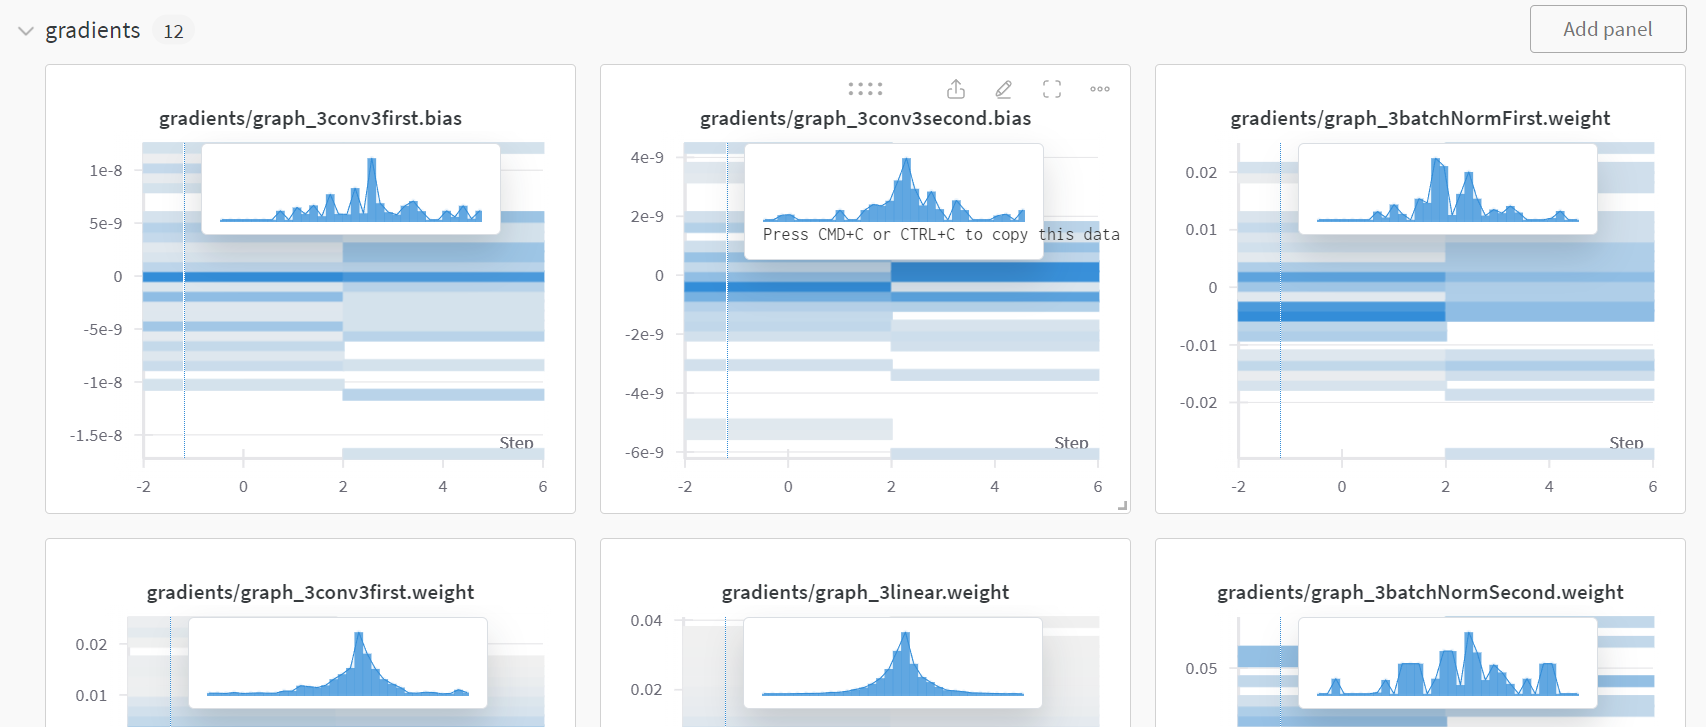

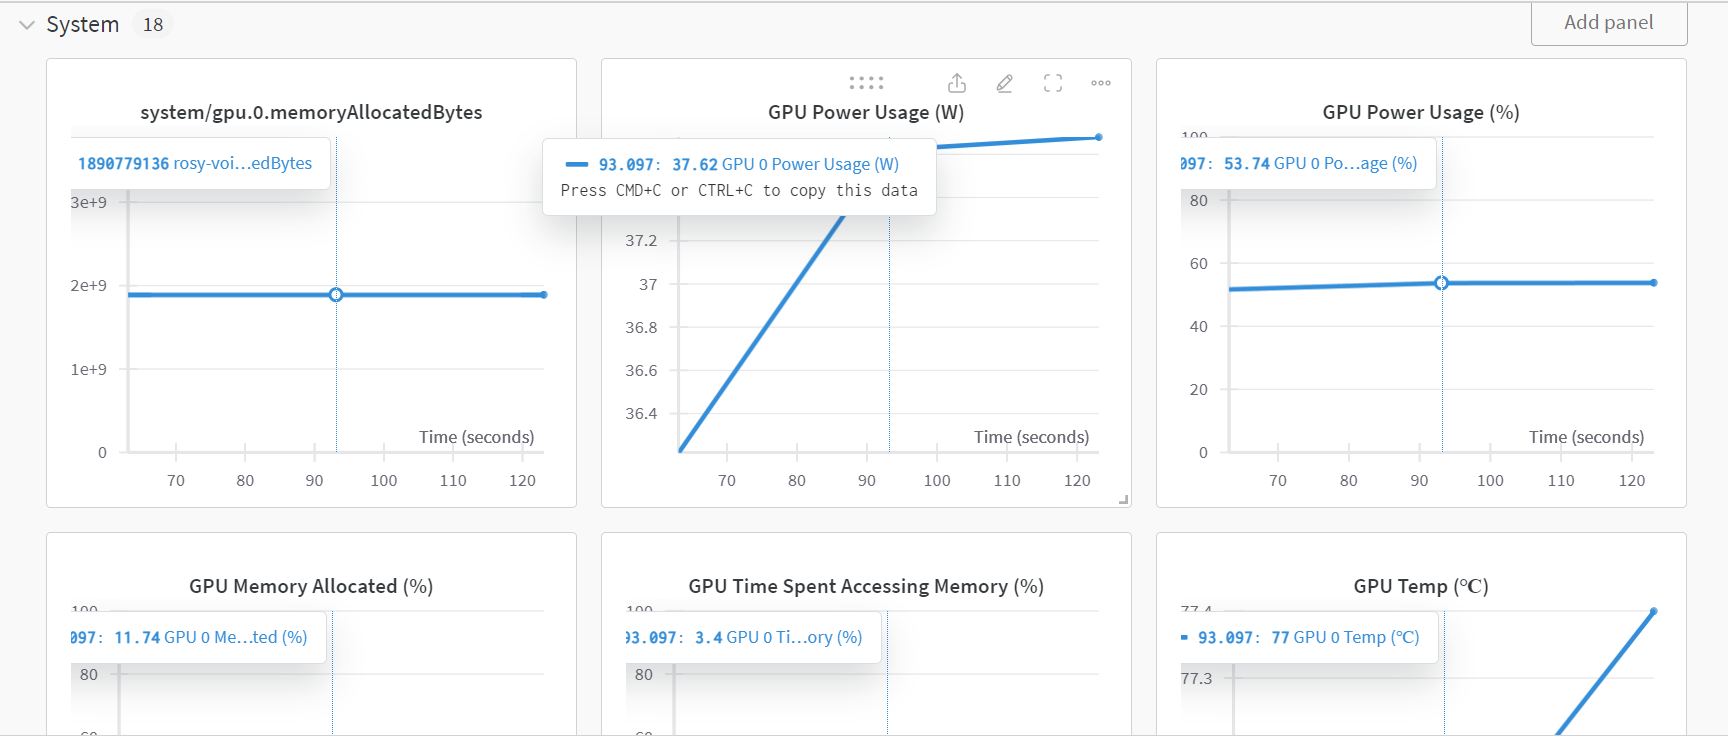

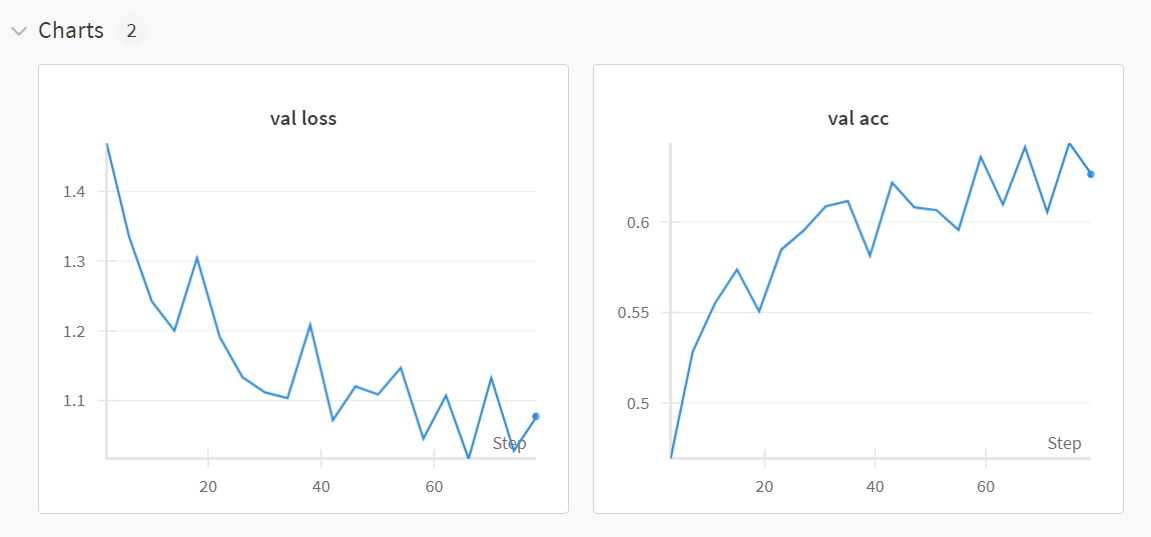